In [1]:
import random
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
def rotate(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    angle = angle
    rot_mat = cv.getRotationMatrix2D(center, angle,1)

    warp_rotate_dst = cv.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]))
    cv.imshow(' Rotate', warp_rotate_dst)
    cv.waitKey(0)
    return warp_rotate_dst

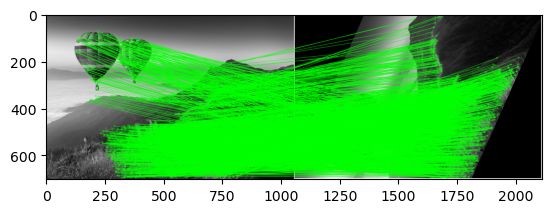

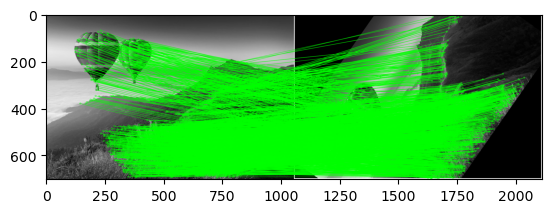

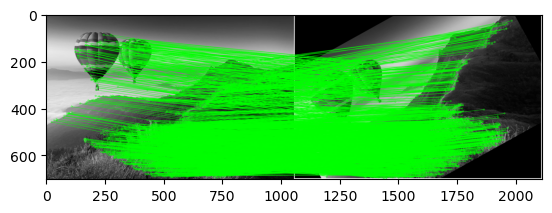

In [8]:
img = cv.imread('sc.png')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
for i in range(3):
    angle= random.randrange(0,360,1)
    ro_gray= rotate(gray, angle)
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(gray,None)
    kp2, des2 = sift.detectAndCompute(ro_gray,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(dst_pts,src_pts , cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = gray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)

        img111= cv.warpPerspective(ro_gray,M, (img.shape[1], img.shape[0]))
        img2 = cv.polylines(ro_gray,[np.int32(pts)],True,255,3, cv.LINE_AA)
        cv.imshow('changed', img111)
        cv.waitKey()
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    # draw matches in green color
    draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = None,
                   # draw only inliers
                   matchesMask = matchesMask, 
                   flags = 2)
    img3 = cv.drawMatches(gray,kp1,ro_gray,kp2,good,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()
